# Requirements

## Basics
The questions you ask are up to you.

- All **four** of your final submitted queries should contain a **JOIN** and **AGGREGATION**.
- At least **two** of your final submitted queries should contain either a **subquery** OR a **CTE**.
- At least **one** of your final submitted queries should contain a **Window Function**.
- At least **one column** generated by the **Window Function** should be included in one of your final **visualization**.
- Check against [the Project Rubic](https://review.udacity.com/#!/rubrics/2095/view)
- Submit [here](https://classroom.udacity.com/nanodegrees/nd104/parts/1954dd2c-6bfd-4d92-b59b-40d6dd298f24/modules/ea7f4990-0e12-4009-ab5d-dfc0353f2505/lessons/3dc22711-adb9-4e58-a299-fc89bce79d86/project)

## Additional Guidelines
- There shouldn’t be any additional data prep (sorting, filtering, renaming, etc.) between the query output and the visualization.

- Once you've finished your project, submit the presentation as a PDF and the queries as a `.txt` file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext sql

from sqlalchemy import create_engine
engine = create_engine('postgresql://localhost/dvdrental')

%sql postgresql://localhost/dvdrental

'Connected: @dvdrental'

# My Work

## Question 1

Which countries are with the most paying customers? 

- Select the Top 5% countries with most paying customers than the rest. 
- List the total number of paying customers for these top countries.

In [397]:
%%sql r <<
WITH t1 AS(
SELECT con.country_id,
       con.country,
       COUNT(DISTINCT p.customer_id) total_paying_customer,
       PERCENT_RANK() OVER(ORDER BY COUNT(cus.customer_id)) as PERCENT_RANK
FROM payment p
JOIN customer cus ON p.customer_id = cus.customer_id
JOIN address a ON cus.address_id = a.address_id
JOIN city c ON c.city_id = a.city_id
JOIN country con ON con.country_id = c.country_id
GROUP BY 1,2)


SELECT t1.country, 
       total_paying_customer 
FROM t1
WHERE PERCENT_RANK >= 0.95
ORDER BY 2 DESC;

 * postgresql://localhost/dvdrental
6 rows affected.
Returning data to local variable r


In [398]:
df = r.DataFrame()
df

,country,total_paying_customer
0,India,60
1,China,53
2,United States,36
3,Japan,31
4,Mexico,30
5,Brazil,28


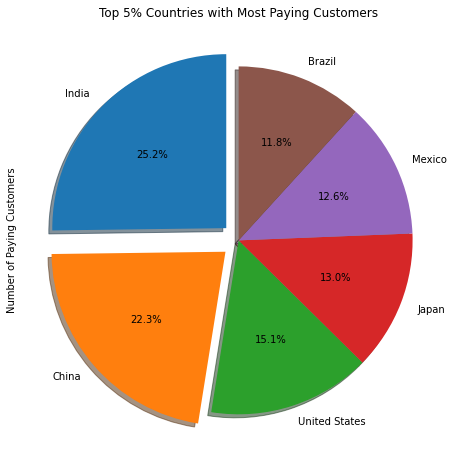

In [399]:
plt.figure(figsize=(10,8))

# only explode those propotions bigger than 40 counts
explode = tuple([0.1 if x>40 else 0 for x in df['total_paying_customer'] ])

plt.pie(df['total_paying_customer'], 
        labels=df['country'],
        autopct='%1.1f%%', explode=explode,
        shadow=True, startangle=90)

# decorate the graph
plt.ylabel('Number of Paying Customers')
plt.title('Top 5% Countries with Most Paying Customers')
plt.show()

**Use the above result to answer the following questions**

- Which 5 hours are most profitable? 
> **Answer**: `13:00`, `17:00`, `05:00`, `02:00` and `03:00` are the 5 most profitable hours.
    
  
- What is the median among all income of different hours?
> **Answer**: There are 24 rows (corresponding to 24 hours) in the results, with the amount ordered, I get `(854 + 851.12)/2 = 852.56`

- Range of the minimum and maximum of different hours?
> **Answer**: The least income is generated at  is `758.09` and the most is `1102.22`, with difference as `344.13`

## Question 2

I'd like to know if, overall speaking, there are peak periods with respect of income generated at different hours **Note: only analyze the data with the Top 5% countries with the most paying customers**

Then I'd compare the income generated at different hours among these countries.

The query result shall show:
- country
- hour (`0:00-23:00`)
- the total income of the hour by country
- the total income of the hour of all top 5% countries

In [585]:
%%sql r <<
WITH t1 AS(
SELECT con.country_id,
       con.country,
       COUNT(DISTINCT p.customer_id) total_paying_customer,
       PERCENT_RANK() OVER(ORDER BY COUNT(cus.customer_id)) as PERCENT_RANK
FROM payment p
JOIN customer cus ON p.customer_id = cus.customer_id
JOIN address a ON cus.address_id = a.address_id
JOIN city c ON c.city_id = a.city_id
JOIN country con ON con.country_id = c.country_id
GROUP BY 1,2),

t2 AS(
SELECT t1.country,
       p.*
FROM payment p
JOIN customer cus ON cus.customer_id = p.customer_id
JOIN address a ON a.address_id = cus.address_id
JOIN city c ON c.city_id = a.city_id
JOIN t1 ON t1.country_id = c.country_id AND t1.PERCENT_RANK > 0.95
)


SELECT DISTINCT country,
       DATE_PART('hour',payment_date) as hour,
       SUM(amount) OVER(PARTITION BY country, DATE_PART('hour',payment_date)) as total_income_by_country_by_yr,
       SUM(amount) OVER(PARTITION BY DATE_PART('hour',payment_date)) as total_income_by_hr
FROM t2
ORDER BY 1,2 DESC;

 * postgresql://localhost/dvdrental
144 rows affected.
Returning data to local variable r


In [586]:
df=r.DataFrame()
df

,country,hour,total_income_by_country_by_yr,total_income_by_hr
0,Brazil,23.0,117.66,988.48
1,Brazil,22.0,134.73,892.82
2,Brazil,21.0,115.78,966.90
3,Brazil,20.0,129.68,902.73
4,Brazil,19.0,147.67,1011.71
...,...,...,...,...
139,United States,4.0,152.66,993.74
140,United States,3.0,162.62,1097.34
141,United States,2.0,126.68,1079.41
142,United States,1.0,98.75,896.88


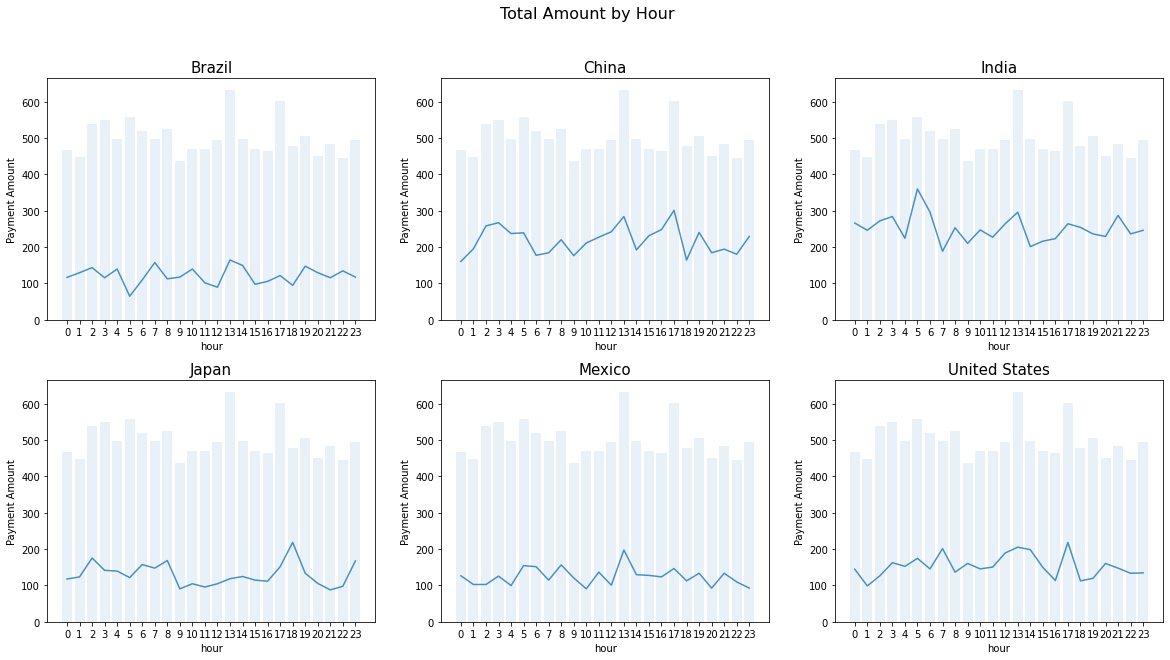

In [587]:
fig = plt.figure(figsize=(20,10))

# display hourly amount by country in plots of different color
i = 1
for c in df.country.unique():
    dt = df[df.country==c]
    fig.add_subplot(2,3,i)
    plt.plot(dt.hour, dt.total_income_by_country_by_yr, alpha=0.8)
    # use half of the total_income values as reference for overall trend
    plt.bar(dt.hour, dt.total_income_by_hr/2, alpha=0.1)
    plt.xticks(range(24))
    plt.xlabel('hour')
    plt.ylabel('Payment Amount')
    plt.title(c, fontsize=15)
    i+=1

fig.suptitle('Total Amount by Hour', fontsize=16)
plt.subplots_adjust(hspace = 0.25)
plt.show()

## Question 3

As observed from the above, India, China and US are the Top 3 countries with most paying customers. Let's look at the difference across monthly payments in these countries during 2007.

In [480]:
%%sql r <<
WITH t1 AS
(SELECT * 
 FROM payment 
 WHERE DATE_PART('year', payment_date) = 2007),

t2 AS
(SELECT con.country, 
        DATE_TRUNC('month', payment_date) pay_mon,
        SUM(amount) pay_amount
FROM t1
JOIN customer cus 
ON t1.customer_id=cus.customer_id
JOIN address a 
ON a.address_id = cus.address_id
JOIN city c 
ON c.city_id = a.city_id
JOIN country con 
ON con.country_id = c.country_id AND con.country IN ('India', 'China', 'United States')
GROUP BY 1,2)

SELECT  country,
        pay_mon,
        pay_amount,
        COALESCE(LEAD(pay_amount, 1) OVER w1, 0) lead,
        (COALESCE(LEAD(pay_amount, 1) OVER w1, 0) - pay_amount) difference
FROM t2
WINDOW w1 AS (PARTITION BY country ORDER BY pay_mon)
ORDER BY 1,2;

 * postgresql://localhost/dvdrental
12 rows affected.
Returning data to local variable r


In [482]:
df = r.DataFrame()
df.head(30)

,country,pay_mon,pay_amount,lead,difference
0,China,2007-02-01,743.23,2061.94,1318.71
1,China,2007-03-01,2061.94,2404.99,343.05
2,China,2007-04-01,2404.99,40.87,-2364.12
3,China,2007-05-01,40.87,0,-40.87
4,India,2007-02-01,667.32,2547.23,1879.91
5,India,2007-03-01,2547.23,2757.46,210.23
6,India,2007-04-01,2757.46,62.77,-2694.69
7,India,2007-05-01,62.77,0,-62.77
8,United States,2007-02-01,474.77,1519.45,1044.68
9,United States,2007-03-01,1519.45,1662.20,142.75


In [492]:
# use this github project: https://github.com/chrispaulca/waterfall

import waterfall_chart
def plot_waterfall(x_col, y_col, filter_by, search, data):
    y = pd.to_numeric(df.loc[df[filter_by]==search, y_col])
    x = df.loc[df[filter_by]==search, x_col]
    waterfall_chart.plot(x,y, rotation_value=60, 
                         formatting='$ {:,.2f}',
                         net_label='Net Difference',
                         y_lab='Difference from last month',
                         Title=search)
    plt.show()

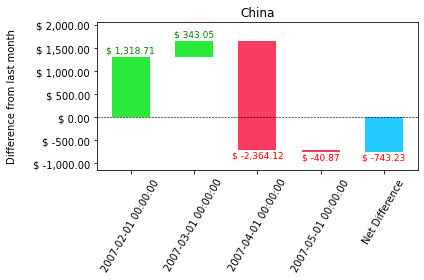

In [493]:
plot_waterfall('pay_mon', 'difference', 'country', 'China', df)

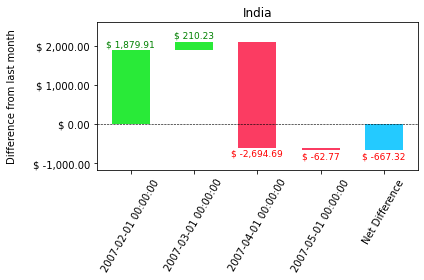

In [494]:
plot_waterfall('pay_mon', 'difference', 'country', 'India', df)

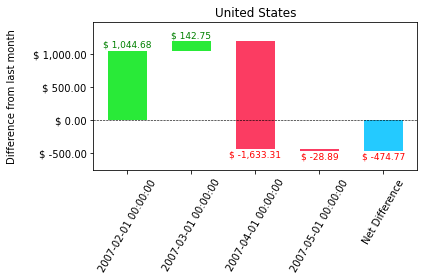

In [495]:
plot_waterfall('pay_mon', 'difference', 'country', 'United States', df)

## Question 4

Which 5 artists are most popular in each of the Top 3 countries? 
- List the count of rentals by actor name for each country.

In [544]:
%%sql r <<
WITH t1 AS(
SELECT DISTINCT con.country, 
       fa.actor_id, 
       COUNT(r.*) OVER (PARTITION BY con.country, fa.actor_id) rental_count
FROM film_actor fa
JOIN film f ON fa.film_id = f.film_id
JOIN inventory i ON i.film_id = f.film_id
JOIN rental r ON r.inventory_id = i.inventory_id
JOIN customer cus ON cus.customer_id = r.customer_id
JOIN address a ON a.address_id = cus.address_id
JOIN city c ON c.city_id = a.city_id
JOIN country con ON con.country_id = c.country_id 
                    AND con.country IN ('China', 'India', 'United States')),

t2 AS (
SELECT *, 
       ROW_NUMBER() OVER (PARTITION BY country 
                          ORDER BY  rental_count DESC) actor_rank
FROM t1
),

t3 AS (
SELECT * 
FROM t2
WHERE actor_rank <= 5)

SELECT country, 
       a.first_name || ' ' ||a.last_name as actor,
       actor_rank, rental_count
FROM actor a 
JOIN t3 ON t3.actor_id = a.actor_id AND t3.rental_count > 1
ORDER BY 1, 3

 * postgresql://localhost/dvdrental
15 rows affected.
Returning data to local variable r


In [545]:
df = r.DataFrame()
df

,country,actor,actor_rank,rental_count
0,China,Gina Degeneres,1,67
1,China,Val Bolger,2,66
2,China,Warren Jackman,3,64
3,China,Ewan Gooding,4,62
4,China,Matthew Carrey,5,61
5,India,Gina Degeneres,1,81
6,India,Matthew Carrey,2,77
7,India,Mary Keitel,3,66
8,India,Albert Johansson,4,66
9,India,Sandra Kilmer,5,66


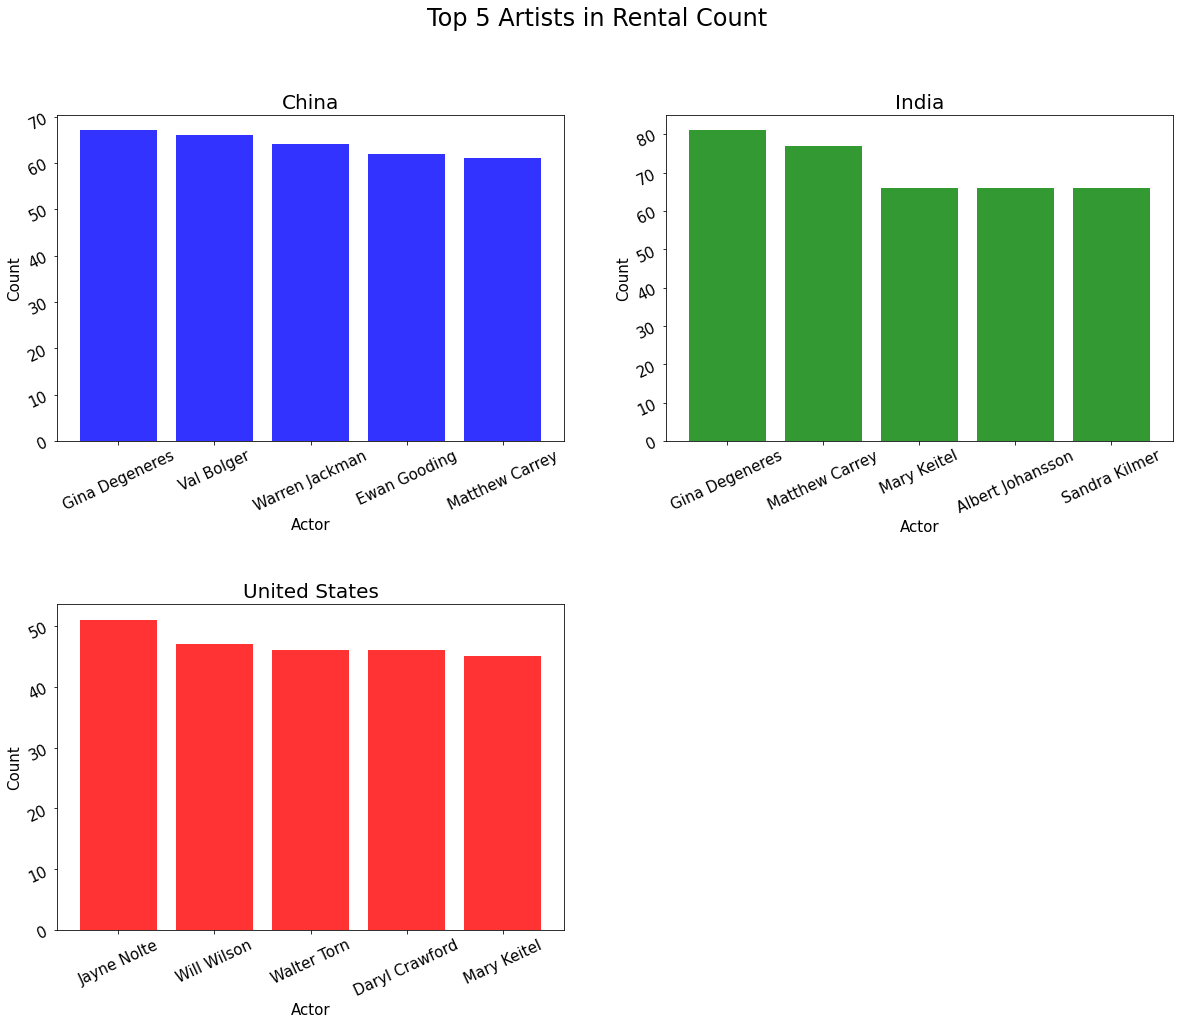

In [577]:
fig = plt.figure(figsize=(20,15))

# display hourly amount by country in plots of different color
colors=['blue', 'green', 'red']
i = 1
for c in df.country.unique():
    dt = df[df.country==c]
    fig.add_subplot(2,2,i)
    plt.bar(dt.actor, dt.rental_count, alpha=0.8, color=colors[i-1])
    plt.tick_params(axis='both', which='major',rotation=25, labelsize=15)
    plt.xlabel('Actor', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.title(c, fontsize=20)
    i+=1

    
fig.suptitle('Top 5 Artists in Rental Count',fontsize=24)
plt.subplots_adjust(hspace = 0.5)
plt.show()